<a href="https://colab.research.google.com/github/Soumyajit-Chakraborty/Data-analysis-project/blob/main/Data_cleaning_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/retail_store_sales.csv')
df.head()

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,NaN
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False


# Beginning with Data Cleaning
## Datatype Issues
* Transaction date -> datetime
* Discount applied -> Boolean
## Missing Data
* Wherever the price per unit column is empty, we have proper values for the quantity and total spent, as proved in a cell below. So for NaN values in price per unit column, we will simply impute that by dividing the total spent by quantity

* Now that we have all the prices, we can deduce the Item Names from the prices per unit and category, using the mapping provided in the documentation

* Also, Price per unit, quantity and total spent are related. We can use this relation to impute missing values when two of the columns are present. But as later analysis will show, there are no rows with 2 values present. Quantity and Total spent are always missing in pairs. Also, they account for less than 5% of the entire data, so it might be wise not to impute them and rather drop the rows.

* For Discount applied, we will assume missing values indicate no discount given, imputing them with false.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    12575 non-null  object 
 1   Customer ID       12575 non-null  object 
 2   Category          12575 non-null  object 
 3   Item              11362 non-null  object 
 4   Price Per Unit    11966 non-null  float64
 5   Quantity          11971 non-null  float64
 6   Total Spent       11971 non-null  float64
 7   Payment Method    12575 non-null  object 
 8   Location          12575 non-null  object 
 9   Transaction Date  12575 non-null  object 
 10  Discount Applied  8376 non-null   object 
dtypes: float64(3), object(8)
memory usage: 1.1+ MB


In [ ]:
df.isnull().sum()

,0
Transaction ID,0
Customer ID,0
Category,0
Item,1213
Price Per Unit,609
Quantity,604
Total Spent,604
Payment Method,0
Location,0
Transaction Date,0


The following cell shows that wherever price per unit is missing, we will have there the quantity and total spent to deduce the price per unit. There are no rows where the price per unit is missing, and also any one (or two) of quantity and total spent is missing.

In [ ]:
df[pd.isna(df['Price Per Unit']) & (pd.isna(df['Quantity']) | pd.isna(df['Total Spent']))]

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied


Impute the calculated value

In [ ]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Total Spent'] / df['Quantity'])

In [ ]:
df.isnull().sum()

,0
Transaction ID,0
Customer ID,0
Category,0
Item,1213
Price Per Unit,0
Quantity,604
Total Spent,604
Payment Method,0
Location,0
Transaction Date,0


### The following mappings have been provided in the documentation for the data
We will be using these mappings to obtain the Item names, from the price and the category. These mappings are provided in the documentation of the data.

In [ ]:
price_to_item_number = {5: 1, 6.5: 2, 8: 3, 9.5: 4, 11: 5, 12.5: 6, 14: 7, 15.5: 8, 17: 9,
                        18.5: 10, 20: 11, 21.5: 12, 23: 13, 24.5: 14, 26: 15, 27.5: 16, 29: 17,
                        30.5: 18, 32: 19, 33.5: 20, 35: 21, 36.5: 22, 38: 23, 39.5: 24, 41: 25
                       }
cat_to_abbr = {'Patisserie':"PAT", 'Milk Products':'MILK', 'Butchers':'BUT', 'Beverages':'BEV', 'Food':'FOOD',
       'Furniture':'FUR', 'Electric household essentials':'EHE',
       'Computers and electric accessories':"CEA"}

### In the following function, we perform the following operation:
* If only item is missing, we can deduce it from category and price
* If item and price per unit are both missing, then use category wise modes to impute the item, and then add its price.
* The function returns the rows, so we can use the `.apply()` method to impute the values

In [ ]:
def fill_item_price(row):
    if pd.isna(row['Item']):
        item_number = price_to_item_number[row['Price Per Unit']]
        category = cat_to_abbr[row['Category']]
        val = f"Item_{item_number}_{category}"
        row['Item'] = val
    return row

In [ ]:
df = df.apply(fill_item_price,axis = 1)

### Item and price columns have been successfully imputed, as can be seen from the following output.

In [ ]:
df.isnull().sum()

,0
Transaction ID,0
Customer ID,0
Category,0
Item,0
Price Per Unit,0
Quantity,604
Total Spent,604
Payment Method,0
Location,0
Transaction Date,0


### As there is no way to figure out `quantity` and `total spent` together, we will drop the rows which have them missing, losing 4.8% of the data

In [ ]:
df = df.dropna(subset = ['Quantity','Total Spent'])

In [ ]:
df.isnull().sum()

,0
Transaction ID,0
Customer ID,0
Category,0
Item,0
Price Per Unit,0
Quantity,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


### Assuming missing discounts are just instances where discounts are not applied, we will impute them with `False`

In [ ]:
df['Discount Applied'] = df['Discount Applied'].fillna("False")

In [ ]:
df.isnull().sum()

,0
Transaction ID,0
Customer ID,0
Category,0
Item,0
Price Per Unit,0
Quantity,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


### Check the validation rule Price Per Unit * Quantity = Total Spent holds or not
Here we can see there are no inconsistencies

In [ ]:
df[df['Price Per Unit']*df['Quantity'] != df['Total Spent']]

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied


### We will fix the datatypes of the columns `Transaction Data` and `Discount Applied`

In [ ]:
df['Discount Applied'] = df['Discount Applied'].astype(bool)
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11971 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    11971 non-null  object        
 1   Customer ID       11971 non-null  object        
 2   Category          11971 non-null  object        
 3   Item              11971 non-null  object        
 4   Price Per Unit    11971 non-null  float64       
 5   Quantity          11971 non-null  float64       
 6   Total Spent       11971 non-null  float64       
 7   Payment Method    11971 non-null  object        
 8   Location          11971 non-null  object        
 9   Transaction Date  11971 non-null  datetime64[ns]
 10  Discount Applied  11971 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(3), object(6)
memory usage: 1.0+ MB


### Check if there are any inconsistent data or not

In [ ]:
for i in 'Customer ID','Category','Price Per Unit','Quantity','Payment Method','Location','Discount Applied':
    print(i)
    print(df[i].unique())
    print()

Customer ID
['CUST_09' 'CUST_22' 'CUST_02' 'CUST_06' 'CUST_05' 'CUST_07' 'CUST_23'
 'CUST_25' 'CUST_14' 'CUST_15' 'CUST_17' 'CUST_10' 'CUST_04' 'CUST_13'
 'CUST_18' 'CUST_08' 'CUST_20' 'CUST_12' 'CUST_11' 'CUST_19' 'CUST_16'
 'CUST_24' 'CUST_21' 'CUST_01' 'CUST_03']

Category
['Patisserie' 'Milk Products' 'Butchers' 'Beverages' 'Food' 'Furniture'
 'Electric household essentials' 'Computers and electric accessories']

Price Per Unit
[18.5 29.  21.5 27.5 12.5 20.   5.  36.5  8.   6.5 39.5 23.  14.  35.
  9.5 24.5 33.5 41.  38.  15.5 11.  32.  26.  30.5 17. ]

Quantity
[10.  9.  2.  7.  8.  1.  3.  6.  4.  5.]

Payment Method
['Digital Wallet' 'Credit Card' 'Cash']

Location
['Online' 'In-store']

Discount Applied
[ True False]



In [ ]:
df.describe()

,Price Per Unit,Quantity,Total Spent,Transaction Date
count,11971.000000,11971.000000,11971.000000,11971
mean,23.360872,5.536380,129.652577,2023-07-13 02:26:23.627099136
min,5.000000,1.000000,5.000000,2022-01-01 00:00:00
25%,14.000000,3.000000,51.000000,2022-09-29 00:00:00
50%,23.000000,6.000000,108.500000,2023-07-13 00:00:00
75%,33.500000,8.000000,192.000000,2024-04-24 00:00:00
max,41.000000,10.000000,410.000000,2025-01-18 00:00:00
std,10.741889,2.857883,94.750697,NaN


# Beginning with Exploratory Data Analysis
## Category wise exploration

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

### What is the most purchased category?

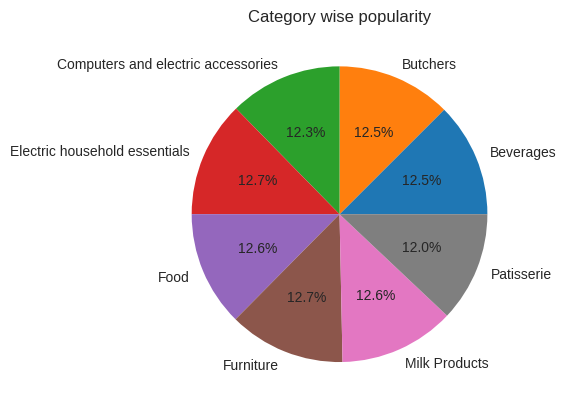

In [ ]:
category_counts = df.groupby('Category')['Transaction ID'].count()
plt.pie(category_counts.values, labels = category_counts.index, autopct='%1.1f%%')
plt.title('Category wise popularity')
plt.show()

### Category wise average sales

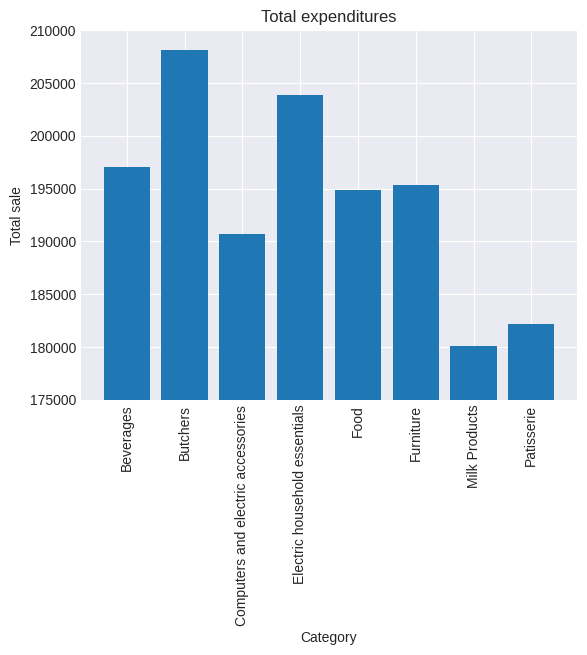

In [ ]:
category_sales = df.groupby("Category")['Total Spent'].sum()
plt.bar(category_sales.index, category_sales.values)
plt.title('Total expenditures')
plt.xlabel('Category')
plt.ylabel('Total sale')
plt.ylim([175000,210000])
plt.xticks(rotation = 90)
plt.show()

## Customer Analysis
1. Customer wise category modes
2. Customer wise item modes
3. Top 5 spending customer
4. customer wise category distribution

### Most purchased categories of each customer
**Question answered:** Which category did each cutomer most frequently buy from?

**Relevance:** Can be useful in targeted advertisement, when certain offers are available on the categories most preferred by the customers

**Process:** We can simply group by the customer IDs and then find the modal category

In [ ]:
# Which categories were most frequently purchased by the 25 customers?
customer_categories = df.groupby('Customer ID')['Category'].agg(lambda x: x.mode())
customer_categories

,Category
Customer ID,
CUST_01,Computers and electric accessories
CUST_02,Electric household essentials
CUST_03,Butchers
CUST_04,Butchers
CUST_05,"[Beverages, Milk Products]"
CUST_06,Computers and electric accessories
CUST_07,Electric household essentials
CUST_08,"[Beverages, Food]"
CUST_09,Milk Products


### Most purchased items by each customer
**Question answered:** Which item was bought by each customer most frequently?

**Relevance:** Provides more granular detail on customer preference. Helps in identification of basket combinations, which can show items frequently brought together by the customer. When one item is purchased, we can prompt the other items, which will increase quality of user experience.

**Process:** We can simply group by the customer IDs and then find the modal category

In [ ]:
# Which Items were most frequently purchased by the 25 customers?
customer_items = df.groupby('Customer ID')['Item'].agg(lambda x: x.mode().iloc[:3])
customer_items

,Item
Customer ID,
CUST_01,Item_5_EHE
CUST_02,"[Item_12_BEV, Item_13_MILK]"
CUST_03,"[Item_23_BUT, Item_25_FOOD]"
CUST_04,"[Item_19_CEA, Item_23_EHE, Item_23_MILK]"
CUST_05,Item_25_BUT
CUST_06,Item_2_BUT
CUST_07,Item_24_FUR
CUST_08,"[Item_13_PAT, Item_15_FUR]"
CUST_09,Item_20_BUT


### Our top 5 customers who had the maximum total value spent
These are the customers who bring in the maximum profit. The retail firm can further provide them with loyalty benefits, such as added discounts or premium memberships at discounted rates

In [ ]:
# Top 5 most spending customers
customer_spends = df.groupby('Customer ID')['Total Spent'].sum()
customer_spends.sort_values(ascending = False).iloc[:5]

,Total Spent
Customer ID,
CUST_24,68452.0
CUST_08,67351.5
CUST_05,66974.5
CUST_16,65570.5
CUST_13,65037.0


### Our top 5 customers by purchase frequency
These are the most frequent visitors of the store. The retail can also provide these customers with added benefits.

In [ ]:
# top 5 most frequently purchasing customer
customer_freq = df.groupby('Customer ID')['Customer ID'].count()
customer_freq.sort_values(ascending = False).iloc[:5]

,Customer ID
Customer ID,
CUST_24,519
CUST_05,516
CUST_13,508
CUST_08,507
CUST_15,501


## Customer category preferences heatmap
Apart from modal categories, we might also be interested in knowing which categories are most frequently purchased from, by each customer. The following pivot table, visualised as a heatmap, gets the job done. We can instantly see the categories a customer is most likely to purchase from. This can help us in various ways, from targeting ads to undertanding category cohesion (categories usually purchased from simultaneusly)

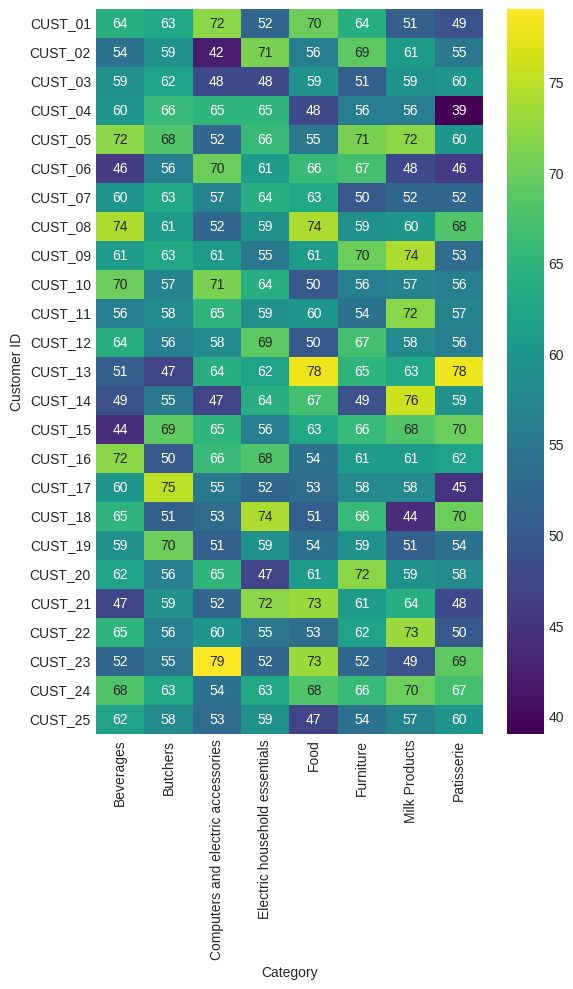

In [ ]:
cust_pref = df.pivot_table(
    index = 'Customer ID',
    columns = 'Category',
    values = 'Transaction ID',
    aggfunc = 'count',
    fill_value = 0
)

fig, ax = plt.subplots(figsize = (6,10))
sns.heatmap(cust_pref,cmap = 'viridis', annot = True, ax = ax)
plt.tight_layout()
plt.show()

## Saving the cleaned data
Saving the cleaned data as a CSV file can help in opening it in supported softwares for further analysis, such as MS Excel, or PowerBI for dashboarding. This portion of EDA is further extended and refined in PowerBI

The following code can be used to save the data in CSV format

`df.to_csv('Cleaned_retail_data.csv')`
